### Threshold the data by the total number of OPC nodes/ in each subsystem and hour.
1. The threshold could be based on OPC nodes (this notebook), cycles (to do), and time/duration (this notebook).
2. Could be weighted (to do).
3. The threshold could be in each hour and subsystem, or accumulated.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
from collections import Counter, OrderedDict
import matplotlib.ticker as ticker

#### 1. Read data.

In [2]:
df = pd.read_csv('plc-2021-04-14.csv', low_memory=False)
luffing_start_end = ('Luffing-Safe brake', True, False)
travel_start_end = ('Traveling-Zero position', True, False)
slewing_start_end = ('Slewing-Motor fan', True, False)
hoisting_start_end = ('Hoist-Work brake', True, False)

#### 2. Count the number of OPC nodes.
In each hour, and fill the gaps with zeros.

In [3]:
def get_counter(keyword):    
#     keyword = 'Travel'
    df_luffing = df[df['opc_node_id'].str.contains(keyword, na=False)]
    timestamps_luffing = df_luffing['timestamp']
    time_structs_luffing = []
    for ts in timestamps_luffing:
        time_end = datetime.datetime.strptime(ts, "%Y-%m-%d %H:%M:%S").timetuple()
        time_structs_luffing.append(time_end)
    hours_consecutive = []
    days = []
    hours_ = []
    for ts in time_structs_luffing:
        day = ts.tm_yday
        if day not in days:
            days.append(day)
        hour = ts.tm_hour
        if hour not in hours_:
            hours_.append(hour)
            hours_.sort()
        day_idx = days.index(day)
        hour_idx = hours_.index(hour)
        hours_consecutive.append(day_idx*24+hour_idx)
    hours_consecutive_counter = Counter(hours_consecutive)
    hours_consecutive_counter = Counter({k:c for k, c in hours_consecutive_counter.items() if c >=10})
    # ignore an hour when there is almost no operation
    return hours_consecutive_counter
traveling_counter = get_counter('Traveling')
luffing_counter = get_counter('Luffing')
slewing_counter = get_counter('Slewing')
hoist_counter = get_counter('Hoist')

In [17]:
def agument(counter):
    '''
    For hours with no OPC nodes, set its value to zero.
    '''
    for _counter in [traveling_counter, luffing_counter, slewing_counter, hoist_counter]:
        for k in _counter.keys():
            if k not in counter:
                counter[k] = 0
    temp = []
    for k, c in counter.items():
        temp.append([k,c])
    return sorted(temp, key=lambda x: x[0])

_traveling_counter = agument(traveling_counter)
_luffing_counter = agument(luffing_counter)
_hoist_counter = agument(hoist_counter)
_slewing_counter = agument(slewing_counter)

In [18]:
print(len(list(traveling_counter.keys())), len(list(luffing_counter.keys())), len(list(slewing_counter.keys())), len(list(hoist_counter.keys())))

239 239 239 239


#### 3. Obtain statistics.

In [19]:
df2 = pd.DataFrame({'Traveling':[x[1] for x in _traveling_counter],
                    'Luffing':[x[1] for x in _luffing_counter],
                    'Slewing':[x[1] for x in _slewing_counter],
                    'Hoist':[x[1] for x in _hoist_counter]})
df2.index = [x[0] for x in _traveling_counter]

In [20]:
df2.describe()

,Traveling,Luffing,Slewing,Hoist
count,239.000000,239.000000,239.000000,239.000000
mean,83.405858,332.606695,733.556485,663.514644
std,82.263198,271.415656,685.443974,556.869384
min,0.000000,0.000000,0.000000,0.000000
25%,26.000000,87.000000,118.500000,142.500000
50%,63.000000,264.000000,622.000000,630.000000
75%,117.000000,523.000000,1137.500000,991.500000
max,472.000000,1294.000000,4098.000000,2445.000000


#### 4. Plot each subsystem above the threshold.

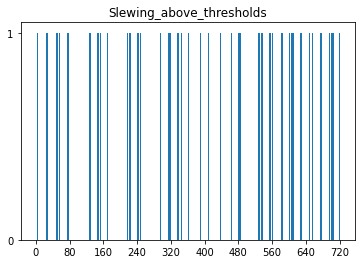

In [13]:
slewing_thresh = 1137
above_thresh = {}
def filter(counter):
    for i in counter:
        k, c = i
        if k not in above_thresh:
            above_thresh[k] = 0
        if c > travel_thresh:
            above_thresh[k] += 1
filter(_slewing_counter)
fig, ax = plt.subplots()
plt.bar(above_thresh.keys(), above_thresh.values())
# Be sure to only pick integer tick locations.
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
title = 'Slewing_above_thresholds'
plt.title(title)
plt.savefig(title+'.png', dpi=200)

#### 5. Plot the sum of subsystems above the threshold.

In [42]:
# Set threshold for each subsystem
travel_thresh = 117
luffing_thresh = 523
slewing_thresh = 1137
hoist_thresh = 991.5

above_thresh = {}
def filter(counter):
    for i in counter:
        k, c = i
        if k not in above_thresh:
            above_thresh[k] = 0
        if c > travel_thresh:
            above_thresh[k] += 1
filter(_traveling_counter)
filter(_luffing_counter)
filter(_hoist_counter)
filter(_slewing_counter)

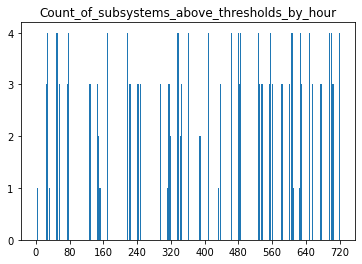

In [56]:
fig, ax = plt.subplots()
plt.bar(above_thresh.keys(), above_thresh.values())
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
title = 'Count_of_subsystems_above_thresholds_by_hour'
plt.title(title)
plt.savefig(title+'.png', dpi=200)

In [59]:
# Print the percentage of hours above threshold in each subsystem.
_c = Counter(list(above_thresh.values()))
for k, v in _c.items():
    print(k, v/239)

#### 6. Plot OPC node counts in each subsystem.

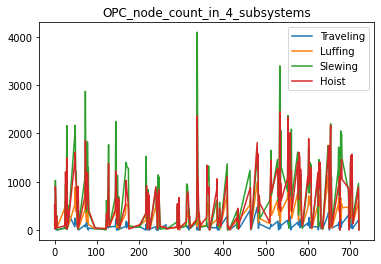

In [21]:
df2.plot()
title = 'OPC_node_count_in_4_subsystems'
plt.title(title)
plt.savefig(title+'.png', dpi=200)